# A Preliminary Analysis of Flint Water Data, with Predictions

### Authors of this short writeup:
* Jacob Abernethy
* Jonathan Stroud
* Jared Webb




## Introduction

What we want to do in this short writeup is give some early results that help to understand the lead level readings that are begin collected en masse in Flint. The plots and tables below are based on two datasets:
- The Department of Environmental Quality (DEQ) testing data obtained from [the Michigan.gov website](http://www.michigan.gov/flintwater/)
- Parcel data obtained from the City of Flint

Don't worry if you are not familiar with the [python programming language](https://www.python.org/), we are including the code below in case others want to build off of our work.

## Here we load the dataset and the code libraries

Again, feel free to ignore the code below if you are not familiar with python.

In [1]:
%matplotlib inline
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
test_data_df = pd.read_csv('joined_data.csv')

safe_rows = test_data_df['Lead (ppb)'] < 15
unsafe_rows = ~safe_rows

unsafe_lats = test_data_df['Latitude'][unsafe_rows].values
unsafe_lons = test_data_df['Longitude'][unsafe_rows].values

## Now let us plot the locations in Flint with elevated lead readings

Keep in mind that a location is determined to have *elevated lead* if the DEQ recorded an amount of **15 parts per billion** in a water sample. The lead readings are known to be highly variable and depend on a number of factors including the time of the day and the number of hours during which water sat idle in the pipes.

In [3]:
bmap = Basemap(llcrnrlon=-83.77, llcrnrlat=42.97, urcrnrlon=-83.61, urcrnrlat=43.08,
            projection='lcc', lat_1=42, lat_2=44, lon_0=-83.65,
            resolution='i', area_thresh=100)
unsafe_xs,unsafe_ys = bmap(unsafe_lons, unsafe_lats)
circle_sizes = np.log10(test_data_df[unsafe_rows]['Lead (ppb)'] + 1)*5


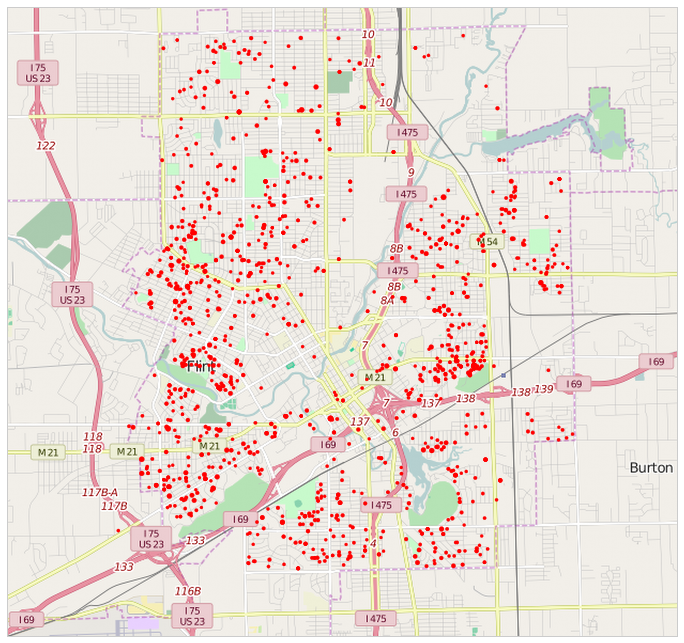

In [4]:
plt.figure().set_size_inches(12,12)
bmap.drawcoastlines(); bmap.drawstates(); bmap.drawcountries();
bmap.scatter(unsafe_xs, unsafe_ys, circle_sizes*1.5, marker='o', color='r', alpha=1)
im = plt.imread('map.png')
bmap.imshow(im, interpolation='lanczos', origin='upper')

## Elevated lead levels are less than 10% of readings

* High lead level readings (i.e. greater than 15 parts per billion) are only about 8.3% of the dataset
* Dangerous lead levels (greater than 50 ppb) make up 2.4% of the data
* The vast majority ( 74% ) of the readings are measuring less than 4 pbb

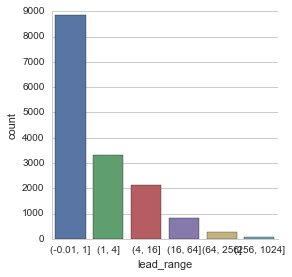

In [5]:
test_data_df['lead_range'] = pd.cut(test_data_df['Lead (ppb)'], bins=[-0.01,1,4,16,64,256,1024])
sns.factorplot(data=test_data_df, x='lead_range', kind="count")

## The **BIG** Question: What is causing high lead levels?

* From the picture above, it's clear that high lead readings are not locally concentrated to any particular region
* What in the data can help us determine which parcels are susceptible to high lead?
* We have played around with the data quite a bit, and we have found various things that seem to correlate heavily with the elevated lead readings


### Important variable: the age of the property

We observed that one attribute of the parcel that is **very** correlated with lead levels is the **year during which the property was built**. We grouped the properties together into six categories, based on the date of construction. We plot the mean of the logarithm of the lead level for each epoch. You'll notice there is a sharp decline for more recently-constructed buildings.

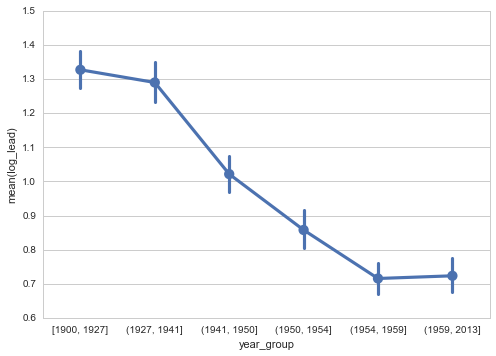

In [6]:
test_data_df['log_lead'] = np.log(1. + test_data_df['Lead (ppb)'])
recent_data = test_data_df[test_data_df['Year Built'] >= 1900].copy()
recent_data['year_group'] = pd.qcut(recent_data['Year Built'],6)
sns.pointplot(x='year_group', y='log_lead',data=recent_data)

### Important variable: Property Use Type

Parcels that are zoned residential test higher on average for lead than commercial parcels.

There are other zoning types present in the data, but they make up less than 1% of the parcels and so we exclude them from this graph.

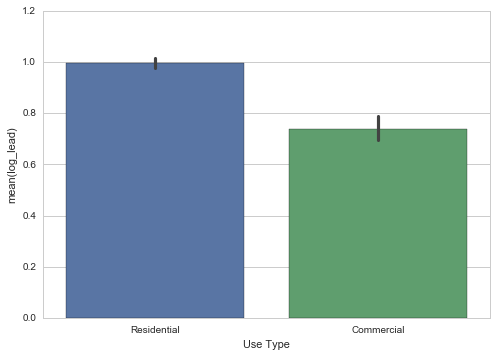

In [7]:
type_data = test_data_df[(test_data_df['Use Type'] == 'Residential').astype(bool) |
                         (test_data_df['Use Type'] == 'Commercial').astype(bool)].copy()

sns.barplot(x='Use Type', y='log_lead', data=type_data)

### Important variable: Number of Storeys

This is a variable that is probably an indicator of something that is not being explicitly measured.  Rather than asking why the number of storeys would affect lead levels, we ask "what do the number of storeys indicate about the building?"

We note that for the majority of the parcels this data is not recorded.  However, for the parcels that do have this data, this is an informative variable.

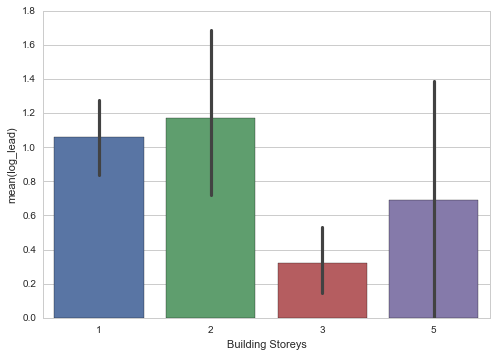

In [8]:
storey_data = test_data_df[test_data_df['Building Storeys'] > 0].copy()
sns.barplot(x='Building Storeys', y='log_lead', data=storey_data)

### Important variable: Property Class

I'm not sure what this means, but certain classes definitely correspond to higher levels.

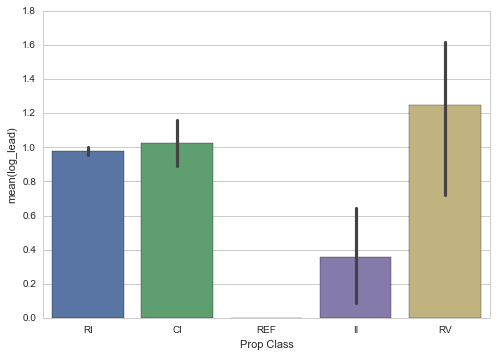

In [9]:
sns.barplot(x='Prop Class', y='log_lead', data=test_data_df)

### Important Variable: Housing Condition

This variable is also important in our models.  It is possible that high lead levels corresponding to poor structural condition indicate that problems with the lead are more than just city infrastructure.

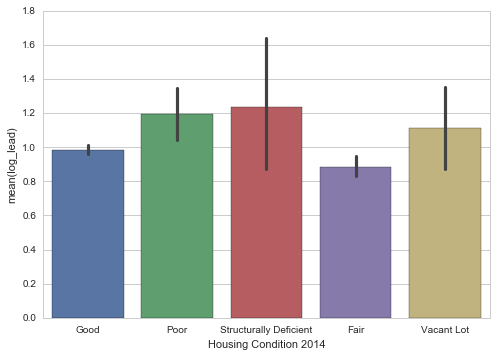

In [10]:
housing_df = test_data_df[test_data_df['Housing Condition 2014'] != ' '].copy()
sns.barplot(x='Housing Condition 2014', y='log_lead', data=housing_df)

## The Next Big Question:  Can we predict future lead measurements?

Using **machine learning** techniques we have built a model that determines a probability that a parcel will have high lead readings.  This model "learns" by discovering patterns in the data from the tested parcels.

### A rough sketch of the Machine Learning methodology:


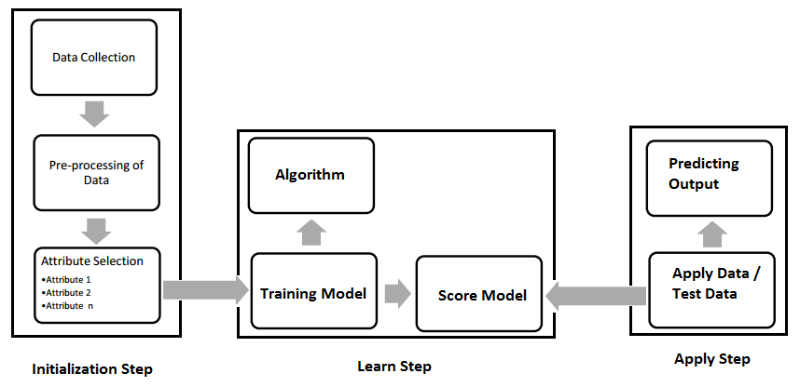

In [11]:
Image(filename='ml_flowchart.png', width='60%')

## Note: Our model uses fire hydrant locations

* City of Flint officials informed us that the fire hydrant types are relevant to determine where lead service line locations
* As a result, we matched every house to its nearest fire hydrant, with the type of hydrant, to be utilized in the model
* We found the hydrant data to be *slightly* predictive, although given the existing parcel data, was only marginally helpful

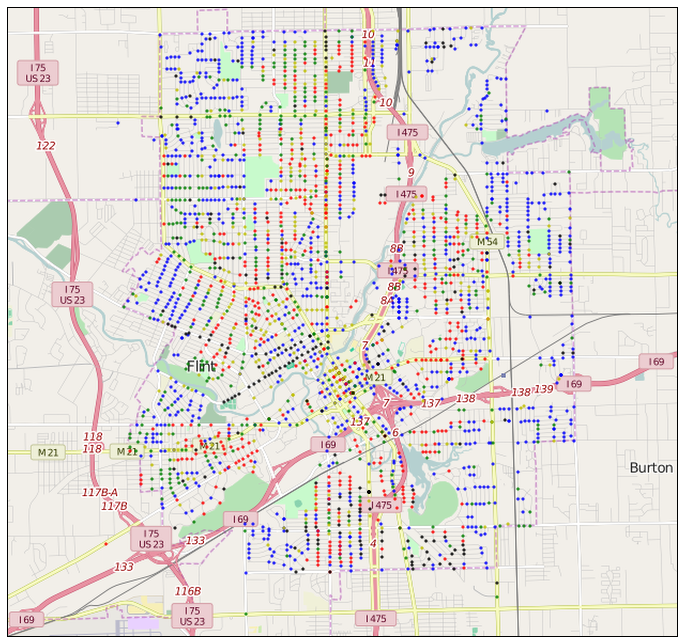

In [12]:
Image(filename='map_of_hydrant_types.png', width='40%')

## What did our model find?

Our model combines a number of features for predicting high lead levels. If we sort these features by relevance, here is what we get:

(Jake: You might want to consolidate these.  For example, features 2-5 could probably just be reduced to "Housing Condition", etc.)

* Year Category_(1954, 1959]
* Housing Condition 2014_Good
* Housing Condition 2012_0
* Housing Condition 2012_Poor
* Housing Condition 2012_ 
* Housing Condition 2014_Structurally Deficient
* Commercial Condition 2013_ 
* Commercial Condition 2013_Good
* Building Storeys_3
* Old Prop class_CV
* Building Storeys_4
* Old Prop class_CI
* Old Prop class_RV
* Old Prop class_RI
* Prop Class_REF
* Prop Class_UV
* Old Prop class_IV
* Prop Class_RI
* Building Storeys_5
* Old Prop class_II
* Use Type_Residential
* Prop Class_RV
* Prop Class_IV
* Use Type_Utility
* Prop Class_II
* Building Storeys_6
* Year Category_(1959, 2013]

### Parcels where we predict dangerous (>50 ppb) lead levels 

Dots correspond to locations with the highest prediction of lead. Note that redder circles correspond to higher probabilities.

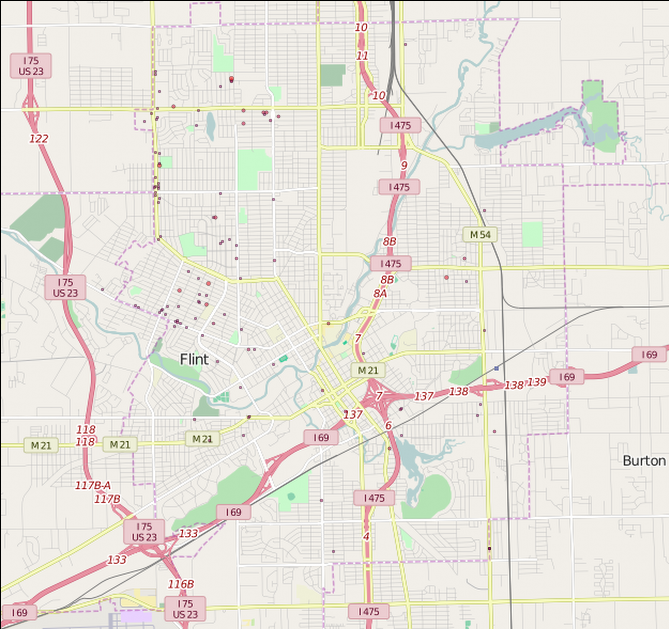

In [17]:
Image(filename='lead_danger.png', width="60%")

### Parcels where we predict elevated (> 15 ppb) lead levels. 

Similar to the previous map, a redder circle corresponds to higher probability that the parcel will have high lead levels.

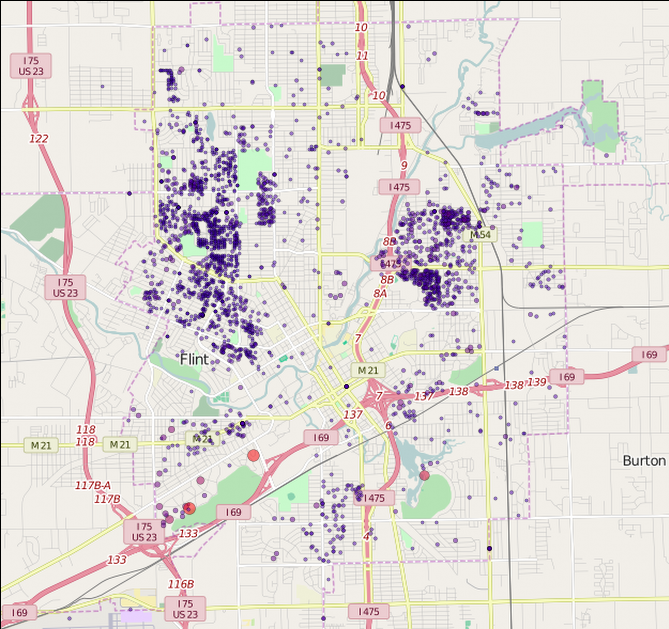

In [18]:
Image(filename='lower_lead_danger.png', width="60%")